In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install timm
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import math
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

from einops.layers.torch import Rearrange
from einops import rearrange

# シード値の設定
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)

batch_size = 128
device = 'cuda'

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 80187221.65it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27499589.97it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21067564.08it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23694687.52it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



In [5]:
# Multi-Head Attentionの実装
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．埋め込み次元数と一致する．
        heads : int
            ヘッドの数．
        dim_head : int
            各ヘッドのデータの次元数．
        dropout : float
            Dropoutの確率(default=0.)．
        """
        super().__init__()

        self.dim = dim
        self.dim_head = dim_head
        inner_dim = dim_head * heads  # ヘッドに分割する前のQ, K, Vの次元数．self.dimと異なっても良い．
        project_out = not (heads == 1 and dim_head == dim)  # headsが1，dim_headがdimと等しければ通常のSelf-Attention

        self.heads = heads
        self.scale = math.sqrt(dim_head)  # ソフトマックス関数を適用する前のスケーリング係数(dim_k)

        self.attend = nn.Softmax(dim=-1)  # アテンションスコアの算出に利用するソフトマックス関数
        self.dropout = nn.Dropout(dropout)

        # Q, K, Vに変換するための全結合層
        self.to_q = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_k = nn.Linear(in_features=dim, out_features=inner_dim)
        self.to_v = nn.Linear(in_features=dim, out_features=inner_dim)

        # dim != inner_dimなら線形層を入れる，そうでなければそのまま出力
        self.to_out = nn.Sequential(
            nn.Linear(in_features=inner_dim, out_features=dim),
            nn.Dropout(dropout),
        ) if project_out else nn.Identity()

    def forward(self, x):
        """
        B: バッチサイズ
        N: 系列長
        D: データの次元数(dim)
        """
        B, N, D = x.size()

        # 入力データをQ, K, Vに変換する
        # (B, N, dim) -> (B, N, inner_dim)
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)

        # Q, K, Vをヘッドに分割する
        # (B, N, inner_dim) -> (B, heads, N, dim_head)
        q = rearrange(q, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        k = rearrange(k, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)
        v = rearrange(v, "b n (h d) -> b h n d", h=self.heads, d=self.dim_head)

        # QK^T / sqrt(d_k)を計算する
        # (B, heads, N, dim_head) x (B, heads, dim_head, N) -> (B, heads, N, N)
        dots = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # ソフトマックス関数でスコアを算出し，Dropoutをする
        attn = self.attend(dots)
        attn = self.dropout(attn)

        # softmax(QK^T / sqrt(d_k))Vを計算する
        # (B, heads, N, N) x (B, heads, N, dim_head) -> (B, heads, N, dim_head)
        out = torch.matmul(attn ,v)

        # もとの形に戻す
        # (B, heads, N, dim_head) -> (B, N, dim)
        out = rearrange(out, "b h n d -> b n (h d)", h=self.heads, d=self.dim_head)

        # 次元が違っていればもとに戻して出力
        # 表現の可視化のためにattention mapも返すようにしておく
        return self.to_out(out), attn

In [6]:
# Feed-Forward Networkの実装
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Arguments
        ---------
        dim : int
            入力データの次元数．
        hidden_dim : int
            隠れ層の次元．
        dropout : float
            各全結合層の後のDropoutの確率(default=0.)．
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=dim, out_features=hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_dim, out_features=dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        (B, D) -> (B, D)
        B: バッチサイズ
        D: 次元数
        """
        return self.net(x)

In [7]:
class Block(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout):
        """
        TransformerのEncoder Blockの実装．

        Arguments
        ---------
        dim : int
            埋め込みされた次元数．PatchEmbedのembed_dimと同じ値．
        heads : int
            Multi-Head Attentionのヘッドの数．
        dim_head : int
            Multi-Head Attentionの各ヘッドの次元数．
        mlp_dim : int
            Feed-Forward Networkの隠れ層の次元数．
        dropout : float
            Droptou層の確率p．
        """
        super().__init__()

        self.attn_ln = nn.LayerNorm(dim)  # Attention前のLayerNorm
        self.attn = Attention(dim, heads, dim_head, dropout)
        self.ffn_ln = nn.LayerNorm(dim)  # FFN前のLayerNorm
        self.ffn = FFN(dim, mlp_dim, dropout)

    def forward(self, x, return_attn=False):
        """
        x: (B, N, dim)
        B: バッチサイズ
        N: 系列長
        dim: 埋め込み次元
        """
        y, attn = self.attn(self.attn_ln(x))
        if return_attn:  # attention mapを返す（attention mapの可視化に利用）
            return attn
        x = y + x
        out = self.ffn(self.ffn_ln(x)) + x

        return out

In [8]:
# Patch Embeddingの実装
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        """
        入力画像をパッチごとに埋め込むための層．

        Arguments
        ---------
        image_size : Tuple[int]
            入力画像のサイズ．
        patch_size : Tuple[int]
            各パッチのサイズ．
        in_channels : int
            入力画像のチャネル数．
        embed_dim : int
            埋め込み後の次元数．
        """
        super().__init__()

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, "パッチサイズは，入力画像のサイズを割り切れる必要があります．"

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # パッチの数
        patch_dim = in_channels * patch_height * patch_width  # 各パッチを平坦化したときの次元数

        self.to_patch_embedding = nn.Sequential(
            Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),  # 画像をパッチに分割して平坦化
            nn.Linear(in_features=patch_dim, out_features=embed_dim),  # 埋め込みを行う
        )

    def forward(self, x):
        """
        B: バッチサイズ
        C: 入力画像のチャネル数
        H: 入力画像の高さ
        W: 入力画像の幅
        """
        return self.to_patch_embedding(x)  # (B, C, H, W) -> (B, num_patches, embed_dim)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

from timm.scheduler import CosineLRScheduler

device = 'cuda'


# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


class VAE(nn.Module):
    def __init__(self, z_dim: int, image_size=[28, 28], patch_size=[2, 2], in_channels=1, emb_dim=384,
                 heads=12, dim_head=32, num_layer=2, mlp_dim=384, dropout=0.) -> None:
        super().__init__()
        self.image_size = image_size
        self.in_channels = in_channels

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.patchify_enc =  nn.Sequential(PatchEmbedding(image_size, patch_size, in_channels, emb_dim))
        self.transformer_enc = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])
        self.dense_enc = nn.Sequential(nn.Linear(mlp_dim*image_size[0]*image_size[1]//patch_size[0]//patch_size[1], 1000),
                                       nn.GELU(),
                                       nn.Linear(1000, 500)
                                       )
        self.dense_encmean = nn.Linear(500, z_dim)
        self.dense_encvar = nn.Linear(500, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Sequential(nn.Linear(z_dim, 1000),
                                       nn.GELU(),
                                       nn.Linear(1000, in_channels*image_size[0]*image_size[1])
                                       )
        self.patchify_dec =  nn.Sequential(PatchEmbedding(image_size, patch_size, in_channels, emb_dim))
        self.transformer_dec = torch.nn.Sequential(*[Block(emb_dim, heads, dim_head, mlp_dim, dropout) for _ in range(num_layer)])
        self.dense_dec2 = nn.Sequential(nn.Linear(mlp_dim*image_size[0]*image_size[1]//patch_size[0]//patch_size[1], 1000),
                                       nn.GELU(),
                                       nn.Linear(1000, in_channels*image_size[0]*image_size[1])
                                       )

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.patchify_enc(x)
        x = self.transformer_enc(x)
        x = F.gelu(torch.flatten(x, 1))
        x = self.dense_enc(x)
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.gelu(self.dense_dec1(z))
        x = self.patchify_dec(x.reshape(-1, self.in_channels, self.image_size[0], self.image_size[1]))
        x = self.transformer_dec(x)
        x = self.dense_dec2(torch.flatten(x, 1))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(x)

        return x.reshape(-1, self.in_channels, self.image_size[0], self.image_size[1])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        transform = transforms.Compose(
            [transforms.RandomRotation(degrees=5.),
            transforms.RandomErasing(p=0.3)]
        )
        mean, std = self._encoder(transform(x.reshape(-1, self.in_channels, self.image_size[0], self.image_size[1])))

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算.
        # torch.sumは上式のDに関するもの. torch.meanはbatch_sizeに関するもの.
        X = torch.flatten(x, 1)
        Y = torch.flatten(y, 1)
        reconstruction = torch.mean(torch.sum(X * torch_log(Y) + (1 - X) * torch_log(1 - Y), dim=1))

        return KL, -reconstruction

In [10]:
z_dim = 10
n_epochs = 20
model = VAE(z_dim, image_size=[28, 28], patch_size=[2, 2], in_channels=1, emb_dim=384,
                 heads=12, dim_head=32, num_layer=2, mlp_dim=384, dropout=0.).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = CosineLRScheduler(optimizer, t_initial=20, lr_min=1e-4,
                                  warmup_t=4, warmup_lr_init=5e-5, warmup_prefix=True)
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x,_ in dataloader_train:
        x = x.to(device)

        model.zero_grad()
        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x,_ in dataloader_valid:

        x = x.to(device).reshape(-1, 1, 28, 28)

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())
    if epoch%20==19:
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/last_params{}_{}.pth".format(epoch, np.average(losses_val)))
    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH:1, Train Lower Bound:181.191238, (7.049397, 174.141830), Valid Lower Bound:146.111816
EPOCH:2, Train Lower Bound:137.711899, (13.563260, 124.148636), Valid Lower Bound:125.588364
EPOCH:3, Train Lower Bound:129.256302, (14.733140, 114.523170), Valid Lower Bound:125.458565
EPOCH:4, Train Lower Bound:124.130005, (15.366221, 108.763779), Valid Lower Bound:119.890770
EPOCH:5, Train Lower Bound:123.049301, (15.714896, 107.334396), Valid Lower Bound:117.980530
EPOCH:6, Train Lower Bound:120.478714, (16.072550, 104.406166), Valid Lower Bound:117.742142
EPOCH:7, Train Lower Bound:117.674927, (16.410048, 101.264877), Valid Lower Bound:117.247032
EPOCH:8, Train Lower Bound:117.598320, (16.516312, 101.082016), Valid Lower Bound:112.167313
EPOCH:9, Train Lower Bound:115.279648, (16.829678, 98.449974), Valid Lower Bound:116.416519
EPOCH:10, Train Lower Bound:115.821693, (16.828617, 98.993080), Valid Lower Bound:110.426575
EPOCH:11, Train Lower Bound:113.757843, (17.054586, 96.703247), Valid Lo

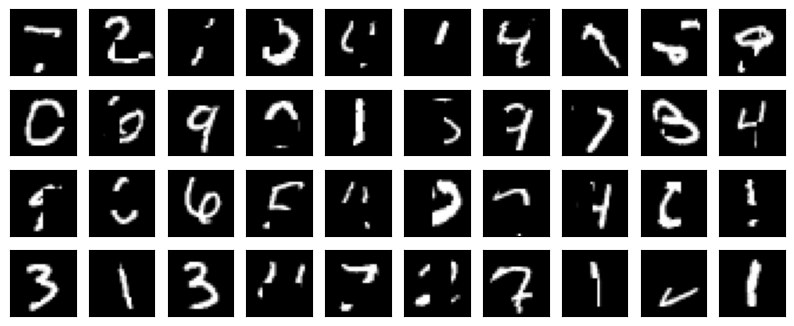

In [50]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=5.),
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x,t = valid_dataset[i]

    x = x.unsqueeze(0).to(device).reshape(-1, 1, 28, 28)

    y, z = model.forward(x)

    im = x.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

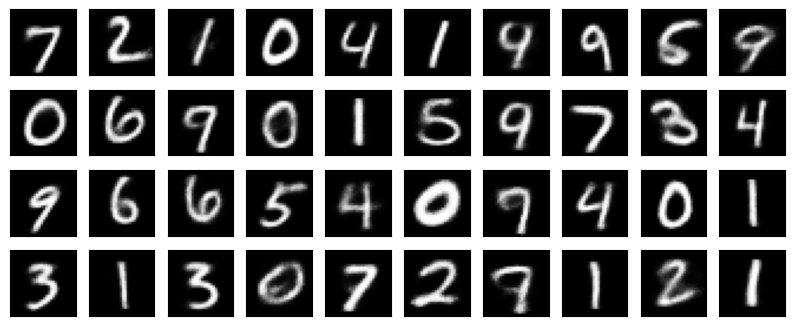

In [51]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=5.),
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x,t = valid_dataset[i]

    x = x.unsqueeze(0).to(device).reshape(-1, 1, 28, 28)

    y, z = model.forward(x)

    im = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')